## 自己相関関数

In [4]:
# Warningsの消去
import warnings
warnings.filterwarnings('ignore')

# モジュールの読み込み
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

# データの読み込み
fname = './data/2020413.csv'
df = pd.read_csv(fname, index_col=0, parse_dates=True, na_values='None', encoding='shift-jis')

# 例として1つ抜き出してみる
col_name = "気化器温度_PV"

acf = sm.tsa.stattools.acf(df[col_name])
print(acf)

[1.         0.62974482 0.62350951 0.60453868 0.61395385 0.61202015
 0.60929824 0.61134841 0.61230394 0.61473471 0.60889061 0.60857538
 0.61025949 0.61053135 0.60902582 0.60661423 0.60890996 0.60705146
 0.60689684 0.60717655 0.60692475 0.60628056 0.60740425 0.60671663
 0.60975835 0.60938884 0.60623177 0.6064455  0.60623949 0.60781058
 0.60603641 0.60813034 0.6048722  0.60773175 0.60724384 0.60875073
 0.60552821 0.60416543 0.6068039  0.60355536 0.60653161 0.60660659
 0.60585572 0.60201769 0.60433313 0.60640586 0.60306943 0.60030697
 0.6016993  0.60316613]


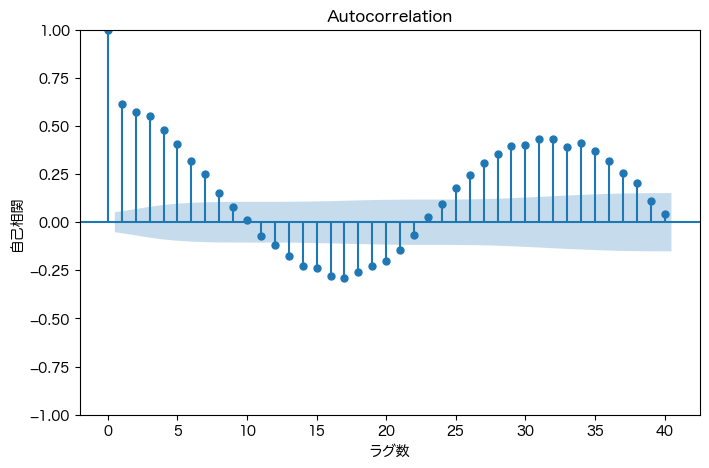

In [7]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(df.loc[::60, col_name], lags=40, ax=ax1) #グラフを自動作成
ax1.set_xlabel('ラグ数')
ax1.set_ylabel('自己相関')
plt.show()
plt.close('all')

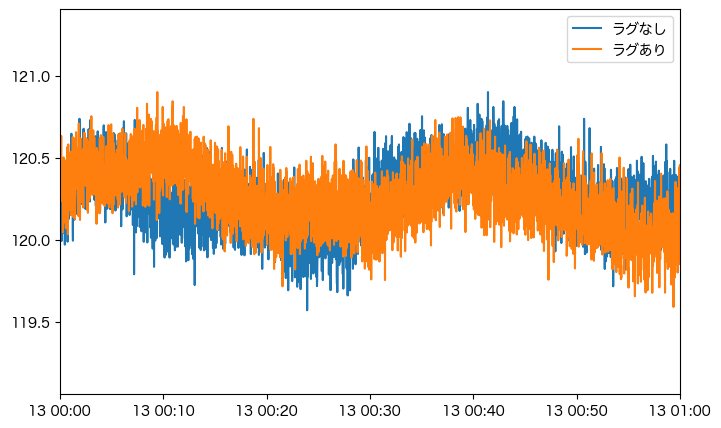

In [8]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(df.index, df[col_name], label='ラグなし')
ax.plot(df.index-timedelta(minutes=32), df[col_name], label='ラグあり')
ax.legend()
ax.set_xlim(datetime(2020, 4, 13, 0), datetime(2020, 4, 13, 1))
plt.show()

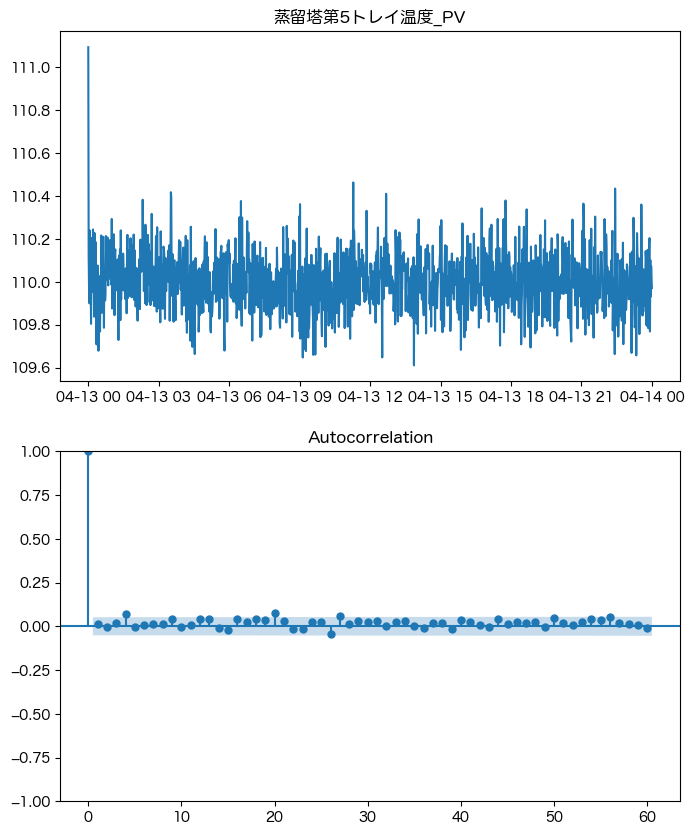

In [9]:
col_name = '蒸留塔第5トレイ温度_PV'
fig = plt.figure(figsize=(8, 10))
fig.tight_layout()
ax1 = fig.add_subplot(211)
ax1.plot(df.index[::60], df.loc[::60, col_name])
ax1.set_title(col_name)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_acf(df.loc[::60, col_name], lags=60, ax=ax2)

plt.show()

### 自己相関がわかるといいこと

・過去の値がどれだけ現在の値に影響しそうか？がわかる

・周期性がわかる

    ・これらの情報から、どのようなモデルを設計すべきかがわかる

・逆に相関がない（ホワイトノイズみたい）場合だと、単変数から回帰することは難しい

    ・解析対象から外したほうがいいかもしれない。あるいは別のモデルを選択すべきかもしれない。という指標になる。

## 編自己相関関数

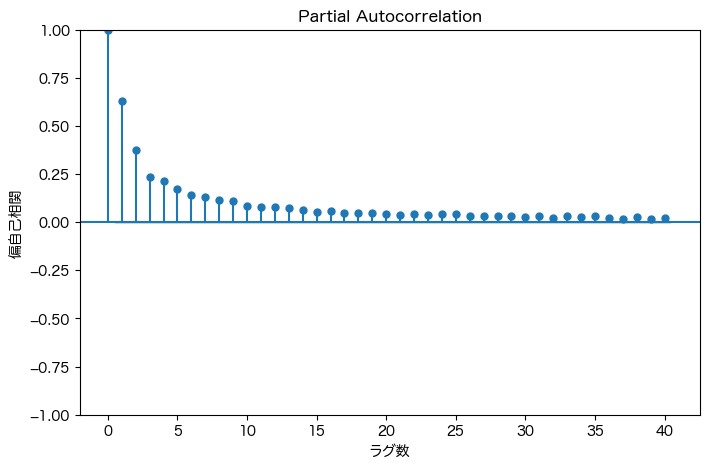

In [11]:
col_name = '気化器温度_PV'

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_pacf(df[col_name], lags=40, ax=ax1) #グラフを自動作成
ax1.set_xlabel('ラグ数')
ax1.set_ylabel('偏自己相関')
plt.show()
plt.close('all')

## 相互相関関数

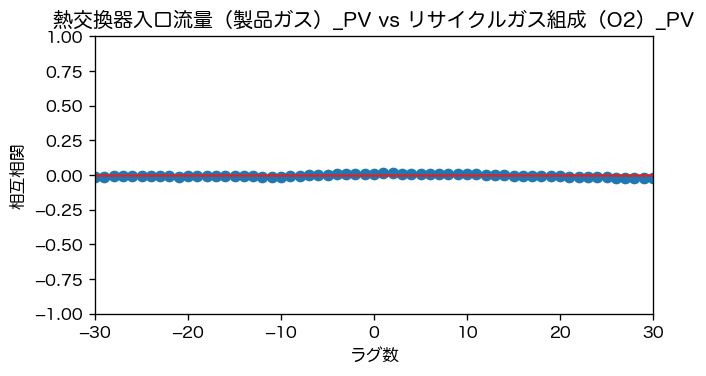

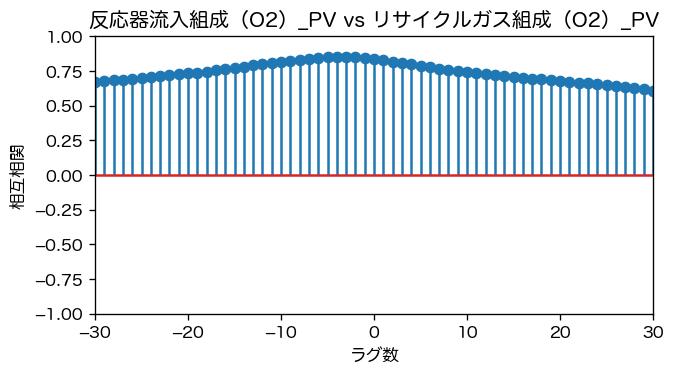

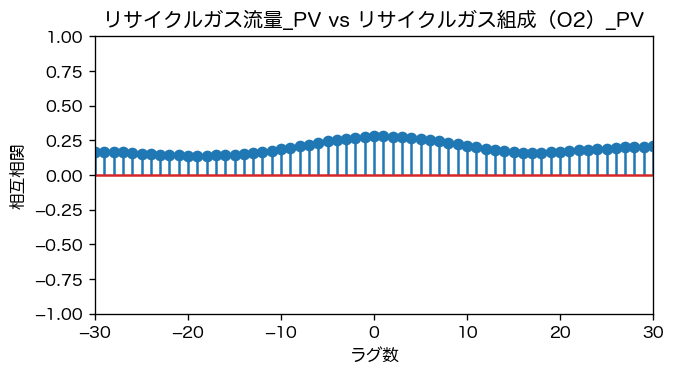

In [12]:
col_obj = 'リサイクルガス組成（O2）_PV'
cols = [ '熱交換器入口流量（製品ガス）_PV', '反応器流入組成（O2）_PV', 'リサイクルガス流量_PV']
plot_size = 60 # プロットするラグの数

y = df.loc[::60, col_obj] #.values

for col in cols:
    x = df.loc[::60, col]
    ccf_xy = sm.tsa.ccf(x, y)[1:plot_size+1]
    ccf_yx = sm.tsa.ccf(y, x)[:plot_size] # (x, y)を基準にしているので、(y, x)はマイナスのラグ 
    ccf = np.concatenate((ccf_yx[::-1], ccf_xy))
    
    x_axis = np.arange(-plot_size, plot_size)
    fig = plt.figure(figsize=(6, 3), dpi=120)
    ax = fig.add_subplot(111)
    ax.stem(x_axis, ccf)
    ax.set_xlim([-30, 30])
    ax.set_ylim([-1, 1])
    ax.set_title('{} vs {}'.format(col, col_obj))
    ax.set_xlabel('ラグ数')
    ax.set_ylabel('相互相関')
    plt.show()

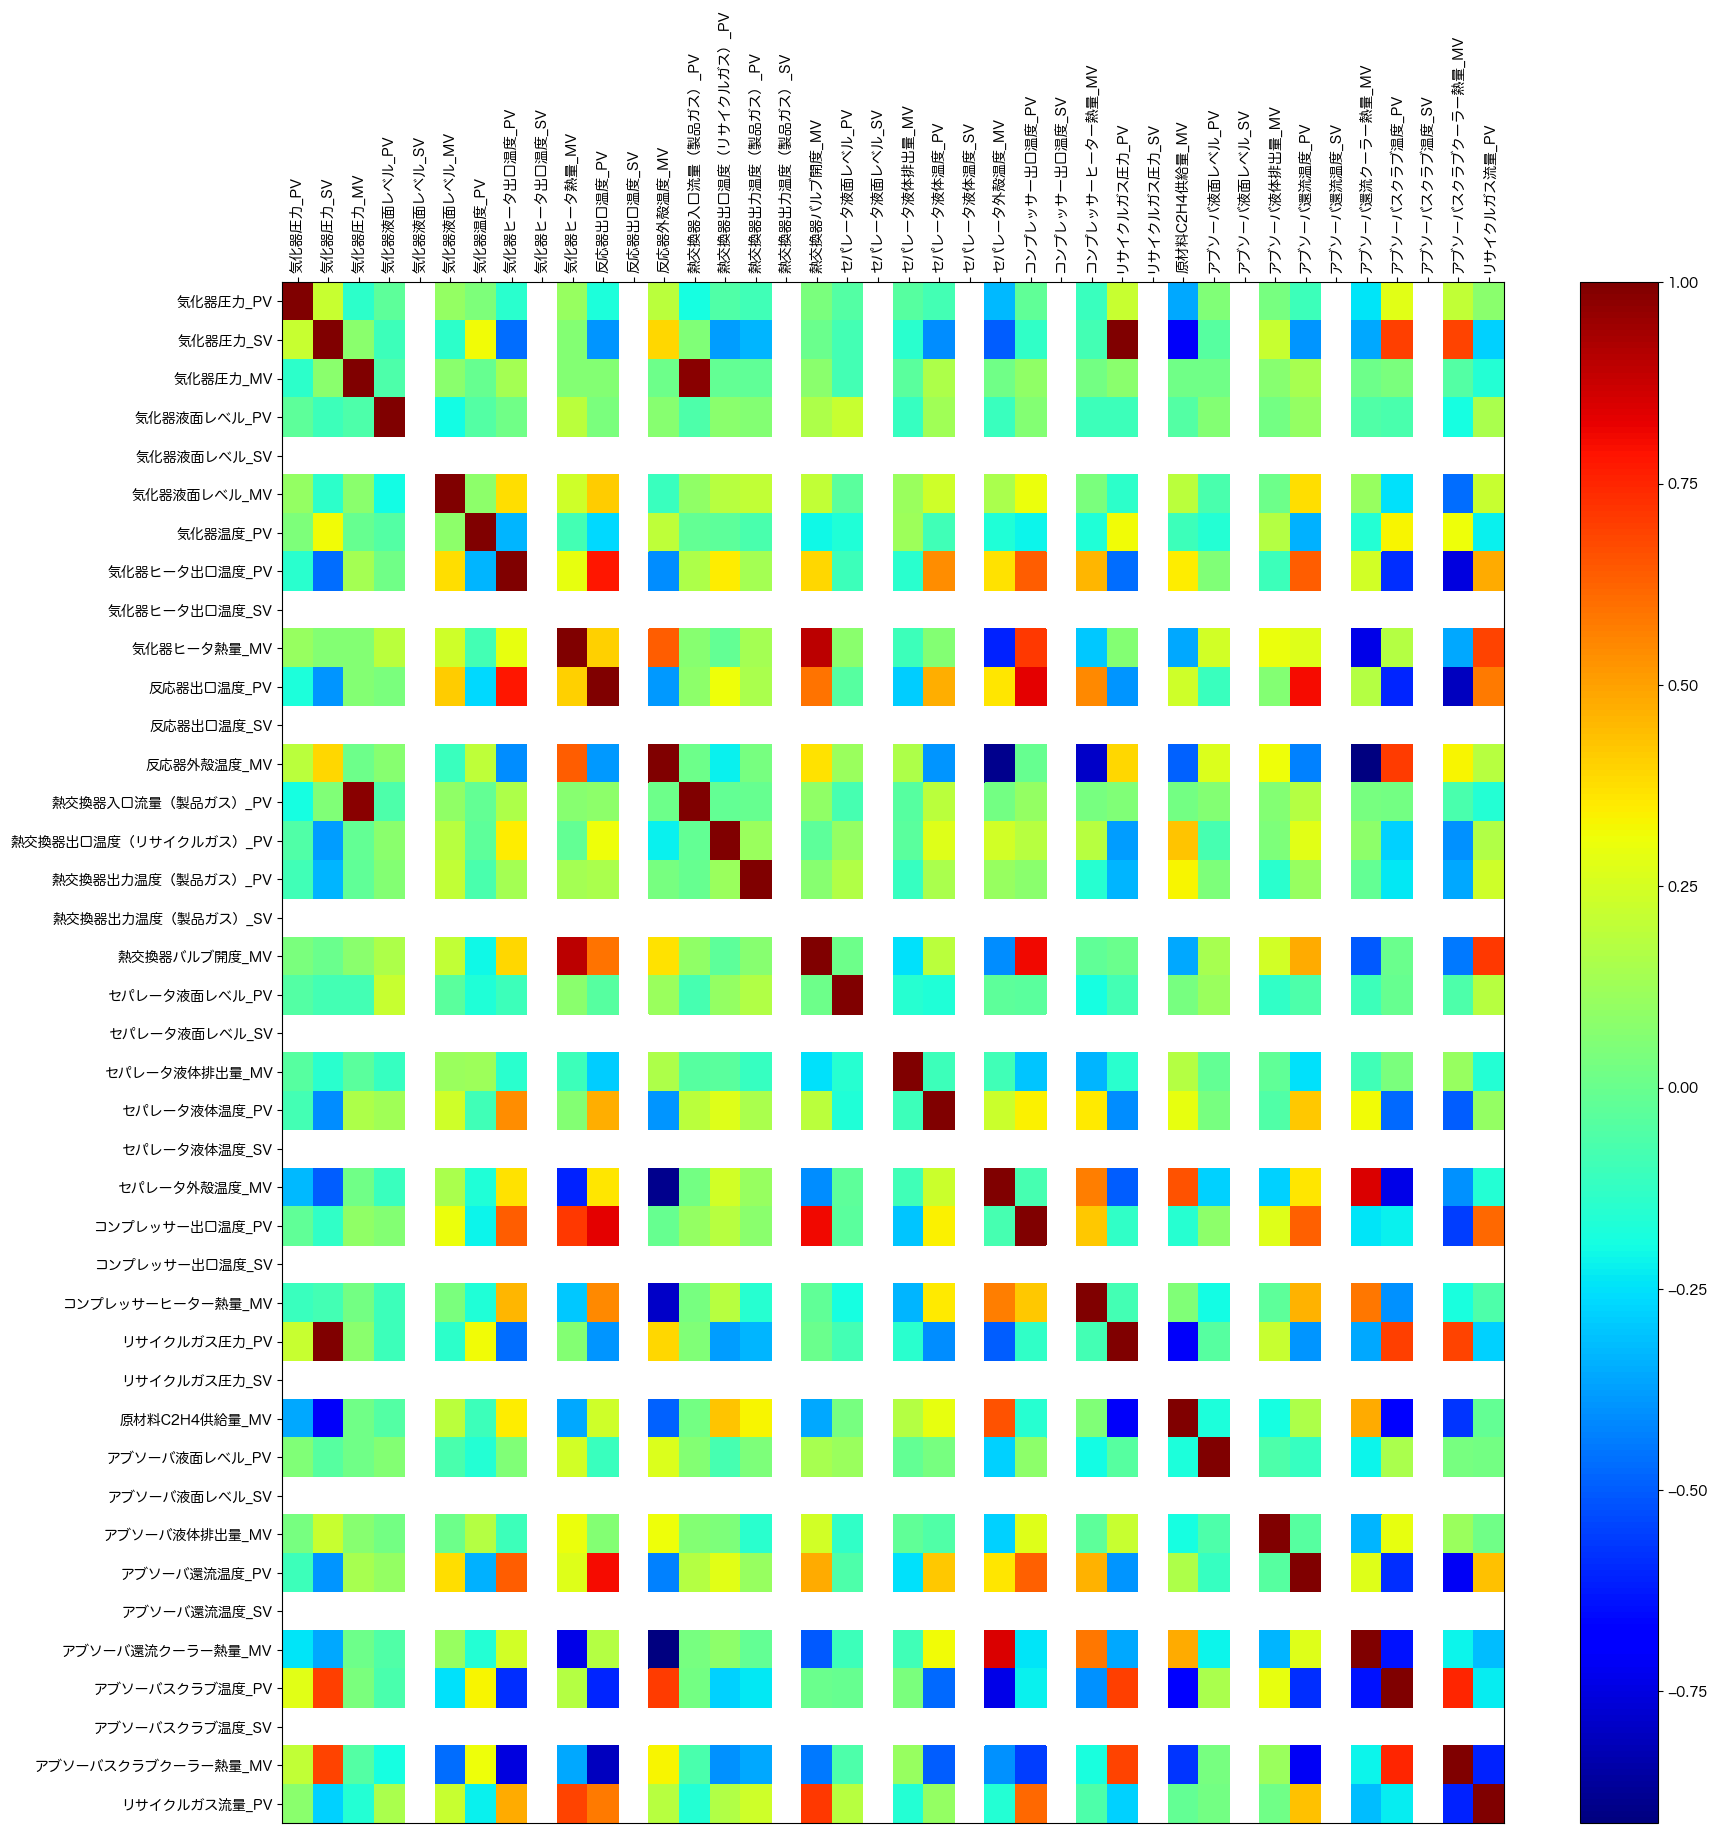

In [13]:
# ヒートマップで表してみる。
# ここではラグなし（k=0）の時をしめす
def plot_corr_heatmap(df, figsize=(16, 16)):
    '''
    相互相関のヒートマップをプロット
    Parameters
    ----------
    df: pandas Dataframe
    figsize: int
        figure size
    Returns
    -------
    
    '''

    df_corr = df.corr() # 相互相関を計算
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout()
    heatmap = ax.pcolor(df_corr, cmap=plt.cm.jet)

    ax.set_xticks(np.arange(df_corr.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(df_corr.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(df_corr.columns.values, minor=False, rotation=90)
    ax.set_yticklabels(df_corr.index.values, minor=False)
    pp = fig.colorbar(heatmap, aspect=20)
    plt.show()
    
# スペースがないので一部だけ表示
plot_corr_heatmap(df.iloc[:60:, :40])